# Opening GeoTIFF and NetCDF files with xarray <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments

## Background
It can be useful open an external raster dataset that you have previously saved to GeoTIFF or NetCDF into a Jupyter notebook in order to conduct further analysis or combine it with other Digital Earth Australia (DEA) data. 
In this example, we will demonstrate how to load in one or multiple GeoTIFF or NetCDF files originally exported to files from a Landsat-8 time-series into an `xarray.Dataset` for further analysis.

For advice on exporting raster data, refer to the [Exporting GeoTIFFs](../Frequently_used_code/Exporting_GeoTIFFs.ipynb) notebook.

For more information on the `xarray` functions used:

* `xarray.open_rasterio` (http://xarray.pydata.org/en/stable/generated/xarray.open_rasterio.html)
* `xarray.open_dataset` (http://xarray.pydata.org/en/stable/generated/xarray.open_dataset.html)
* `xarray.open_mfdataset` (http://xarray.pydata.org/en/stable/generated/xarray.open_mfdataset.html)

## Description
This notebook shows how to open raster data from file using `xarray`'s built-in fuctions for handling GeoTIFF and NetCDF files:

1. Opening single raster files
    * Opening a single GeoTIFF file
    * Opening a single NetCDF file
2. Opening multiple raster files as an `xarray.Dataset` with a time dimension
    * Opening multiple GeoTIFF files
    * Opening multiple NetCDF files

***

## Getting started
 To run this example, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages


In [1]:
%matplotlib inline

import glob
import xarray as xr
from dea_tools.plotting import rgb
from dea_tools.datahandling import paths_to_datetimeindex


## Opening a single raster file


### Define file paths
In the code below we define the locations of the GeoTIFF and NetCDF files that we will open.
These files were originally exported from the GA Landsat 8 `ga_ls8c_ard_3` product. GeoTIFF files contain a single satellite band (`nbart_red`), while NetCDF files contain three satellite bands (`nbart_red`, `nbart_green`, `nbart_blue`).

In [2]:
geotiff_path = '../Supplementary_data/Opening_GeoTIFFs_NetCDFs/geotiff_red_2018-01-03.tif'
netcdf_path = '../Supplementary_data/Opening_GeoTIFFs_NetCDFs/netcdf_2018-01-03.nc'

### Opening a single GeoTIFF

To open a geotiff we use `xarray.open_rasterio()` function which is built around the `rasterio` Python package.
When dealing with extremely large rasters, this function can be used to load data as a Dask array by providing a `chunks` parameter (e.g. `chunks={'x': 1000, 'y': 1000}`). This can be useful to reduce memory usage by only loading the specific portion of the raster you are interested in.

In [3]:
# Open into an xarray.DataArray
geotiff_da = xr.open_rasterio(geotiff_path)

# Covert our xarray.DataArray into a xarray.Dataset
geotiff_ds = geotiff_da.to_dataset('band')

# Rename the variable to a more useful name
geotiff_ds = geotiff_ds.rename({1: 'red'})

We can plot the data to verify it loaded correctly:

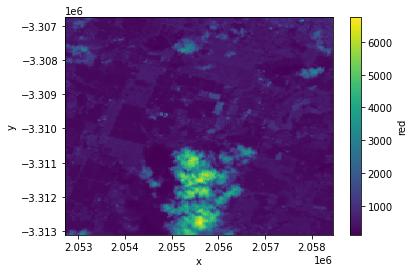

In [4]:
geotiff_ds.red.plot()

### Opening a single NetCDF

To open a NetCDF file we can use `xarray.open_dataset()`. Similarly to the GeoTIFF example above, this function can also be used to open large NetCDF files as Dask arrays by providing a `chunks` parameter (e.g. `chunks={'x': 1000, 'y': 1000}`).

In [5]:
# Open into an xarray.DataArray
netcdf_ds = xr.open_dataset(netcdf_path)

# We can use 'squeeze' to remove the single time dimension
netcdf_ds = netcdf_ds.squeeze('time')
netcdf_ds

<xarray.Dataset>
Dimensions:      (x: 191, y: 212)
Coordinates:
    time         datetime64[ns] 2018-01-03T23:42:39
  * y            (y) float64 -3.307e+06 -3.307e+06 ... -3.313e+06 -3.313e+06
  * x            (x) float64 2.053e+06 2.053e+06 ... 2.058e+06 2.058e+06
Data variables:
    crs          int32 ...
    nbart_red    (y, x) float32 ...
    nbart_green  (y, x) float32 ...
    nbart_blue   (y, x) float32 ...
Attributes:
    date_created:           2019-12-04T16:19:10.855359
    Conventions:            CF-1.6, ACDD-1.3
    history:                NetCDF-CF file created by datacube version '1.7+1...
    geospatial_bounds:      POLYGON ((153.390117090279 -28.8513061571954,153....
    geospatial_bounds_crs:  EPSG:4326
    geospatial_lat_min:     -28.907213271165624
    geospatial_lat_max:     -28.842781641136636
    geospatial_lat_units:   degrees_north
    geospatial_lon_min:     153.39011709027872
    geospatial_lon_max:     153.45973914140396
    geospatial_lon_units:   degrees_east

Because the NetCDF file we loaded using `xarray` contain multiple satellite bands (e.g. `nbart_red`, `nbart_green`, `nbart_blue`), we can plot the result in true colour:

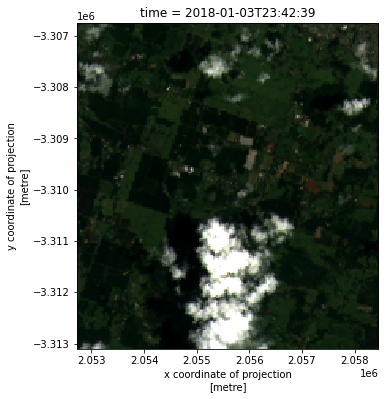

In [6]:
rgb(netcdf_ds)

## Loading multiple files into a single xarray.Dataset

Geospatial time series data is commonly stored as multiple individual files with one time-step per file. 
These are difficult to use individually, so it can be useful to load multiple files into a single `xarray.Dataset` prior to analysis.
This also allows us to analyse data in a format that is directly compatible with data directly loaded from the Datacube.

### Multiple GeoTIFFs

To load multiple GeoTIFF files into a single `xarray.Dataset`, we first need to obtain a list of the files using the `glob` package.
In the example below, we return a list of any files that match the pattern `geotiff_*.tif`:

In [7]:
geotiff_list = glob.glob('../Supplementary_data/Opening_GeoTIFFs_NetCDFs/geotiff_*.tif')
geotiff_list

['../Supplementary_data/Opening_GeoTIFFs_NetCDFs/geotiff_red_2018-01-03.tif',
 '../Supplementary_data/Opening_GeoTIFFs_NetCDFs/geotiff_red_2018-03-24.tif',
 '../Supplementary_data/Opening_GeoTIFFs_NetCDFs/geotiff_red_2018-01-19.tif']

We now read these files using `xarray`. 
To ensure each raster is labelled correctly with its time, we can use the helper function `paths_to_datetimeindex()` from `dea_datahandling` to extract time information from the file paths we obtained above.
We then load and concatenate each dataset along the `time` dimension using `xarray.open_rasterio()`, convert the resulting `xarray.DataArray` to a `xarray.Dataset`, and give the variable a more useful name (`red`):


In [8]:
# Create variable used for time axis
time_var = xr.Variable('time', paths_to_datetimeindex(geotiff_list, 
                                                      string_slice=(12, -4)))

# Load in and concatenate all individual GeoTIFFs
geotiffs_da = xr.concat([xr.open_rasterio(i) for i in geotiff_list], 
                        dim=time_var)

# Covert our xarray.DataArray into a xarray.Dataset
geotiffs_ds = geotiffs_da.to_dataset('band')

# Rename the variable to a more useful name
geotiffs_ds = geotiffs_ds.rename({1: 'red'})

# Print the output
print(geotiffs_ds)


<xarray.Dataset>
Dimensions:  (time: 3, x: 191, y: 212)
Coordinates:
  * y        (y) float64 -3.307e+06 -3.307e+06 ... -3.313e+06 -3.313e+06
  * x        (x) float64 2.053e+06 2.053e+06 2.053e+06 ... 2.058e+06 2.058e+06
  * time     (time) datetime64[ns] 2018-01-03 2018-03-24 2018-01-19
Data variables:
    red      (time, y, x) int16 411 422 404 396 509 ... 3595 3709 2794 2394 2643
Attributes:
    transform:      (30.0, 0.0, 2052720.0, 0.0, -30.0, -3306750.0)
    crs:            +init=epsg:3577
    res:            (30.0, 30.0)
    is_tiled:       1
    nodatavals:     (0.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area


To verify the data was loaded correctly, we can plot it using `xarray`:

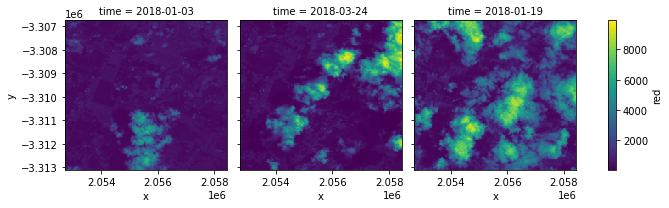

In [9]:
geotiffs_ds.red.plot(col='time')

### Multiple NetCDFs
The `xarray.open_mfdataset()` function can be used to easily load multiple NetCDFs into a single `xarray.Dataset`.
First, we obtain file paths for the files we want to load using `glob`:

In [10]:
netcdf_list = glob.glob('../Supplementary_data/Opening_GeoTIFFs_NetCDFs/netcdf_*.nc')
netcdf_list

['../Supplementary_data/Opening_GeoTIFFs_NetCDFs/netcdf_2018-01-03.nc',
 '../Supplementary_data/Opening_GeoTIFFs_NetCDFs/netcdf_2018-03-24.nc',
 '../Supplementary_data/Opening_GeoTIFFs_NetCDFs/netcdf_2018-01-19.nc']

We then load in the NetCDF files using `xarray.open_mfdataset`. 
Because the NetCDF file format already contains time information for each dataset, we do not need to set up a time variable like in the previous GeoTIFF example.

In [11]:
netcdfs_ds = xr.open_mfdataset(paths=netcdf_list, combine='by_coords')
netcdfs_ds 

<xarray.Dataset>
Dimensions:      (time: 3, x: 191, y: 212)
Coordinates:
  * y            (y) float64 -3.307e+06 -3.307e+06 ... -3.313e+06 -3.313e+06
  * x            (x) float64 2.053e+06 2.053e+06 ... 2.058e+06 2.058e+06
  * time         (time) datetime64[ns] 2018-01-03T23:42:39 ... 2018-03-24T23:...
Data variables:
    crs          (time) int32 -2147483647 -2147483647 -2147483647
    nbart_red    (time, y, x) float32 dask.array<chunksize=(1, 212, 191), meta=np.ndarray>
    nbart_green  (time, y, x) float32 dask.array<chunksize=(1, 212, 191), meta=np.ndarray>
    nbart_blue   (time, y, x) float32 dask.array<chunksize=(1, 212, 191), meta=np.ndarray>
Attributes:
    date_created:           2019-12-04T16:19:10.855359
    Conventions:            CF-1.6, ACDD-1.3
    history:                NetCDF-CF file created by datacube version '1.7+1...
    geospatial_bounds:      POLYGON ((153.390117090279 -28.8513061571954,153....
    geospatial_bounds_crs:  EPSG:4326
    geospatial_lat_min:     -28.907213271165624
    geospatial_lat_max:     -28.842781641136636
    geospatial_lat_units:   degrees_north
    geospatial_lon_min:     153.39011709027872
    geospatial_lon_max:     153.45973914140396
    geospatial_lon_units:   degrees_east

Because the NetCDF files we loaded using `xarray` contain multiple satellite bands (e.g. `nbart_red`, `nbart_green`, `nbart_blue`), we can plot the result in true colour:

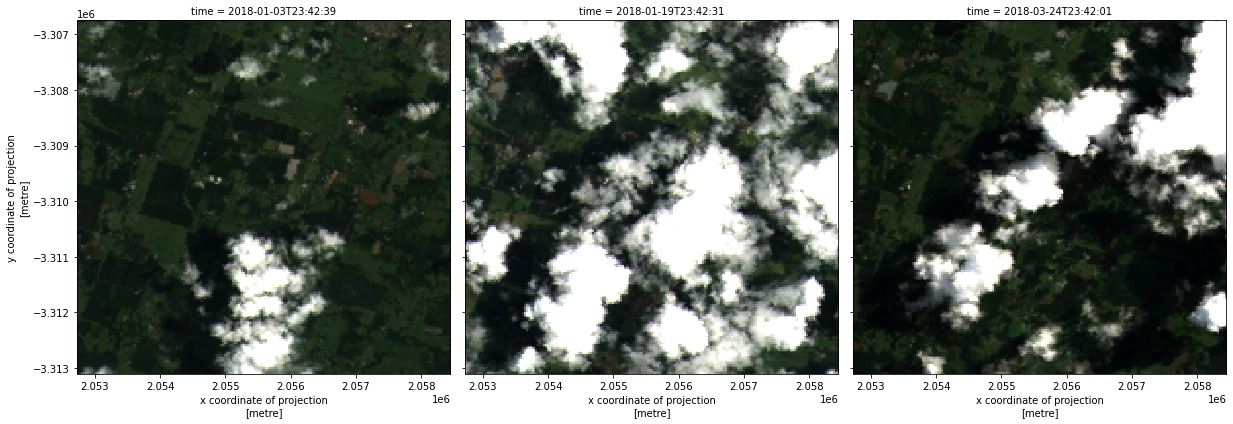

In [12]:
rgb(netcdfs_ds, col='time', percentile_stretch=(0.0, 0.9))

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** November 2020

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)